# Pattern Detection & Technical Indicators Strategy

### Download & Import Important Libraries

In [2]:
#!pip install yfinance mplfinance pandas --quiet
#!pip install --upgrade yfinance==0.2.59

In [3]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import os

%matplotlib inline

## Supporting Functions

### Data Collector Function

In [4]:
def StockDataCollector(ticker_symbol, start, end):
    """
    Downloads historical stock data using yfinance and saves it as a CSV file.

    Parameters:
    - ticker_symbol (str): The stock ticker symbol (e.g., 'AAPL' for Apple Inc.)
    - start (str): Start date in 'YYYY-MM-DD' format
    - end (str): End date in 'YYYY-MM-DD' format

    Example:
    >>> StockDataCollector('AAPL', start='2024-04-01', end='2025-04-30')

    This will download data for Apple Inc. and save it to:
    '../data/AAPL_2024-04-01_to_2025-04-30.csv'

    Returns:
    - 1 on success
    - 0 if an exception occurs
    """
    import yfinance as yf
    import pandas as pd

    try:
        # Download historical stock data from Yahoo Finance
        stock_data = yf.download(ticker_symbol, start=start, end=end)

        # Export the data to CSV in the ../data directory
        stock_data.to_csv(f'../data/{ticker_symbol}_{start}_to_{end}.csv', index=True)

        return 1

    except Exception as e:
        # Handle any error during download or file export
        print("An exception occurred:", e)
        return 0

### DataLoder Function

In [5]:
def DataLoder(path):
    """
    Load and preprocess stock data from a CSV file (downloaded via yfinance).

    Parameters:
    - path (str): File path to the CSV data.

    Returns:
    - pd.DataFrame: Cleaned and formatted stock data with 'Date' as the index.
                    Returns 0 if the file doesn't exist or an error occurs.

    Processing Steps:
    - Checks if the file exists
    - Reads CSV and removes extra non-stock rows
    - Renames the 'Price' column to 'Date'
    - Converts 'Date' to datetime format
    - Converts all other columns to float
    - Sets 'Date' as the index
    """
    import pandas as pd
    import numpy as np
    import os

    try:
        # Check if file exists
        isExist = os.path.exists(path)
        if not isExist:
            return 0
        
        # Load CSV data
        stock_data = pd.read_csv(path)

        # Remove unwanted metadata rows if present
        if stock_data['Price'][0] == 'Ticker':
            stock_data = stock_data[1:]
        if stock_data['Price'][1] == 'Date':
            stock_data = stock_data[1:]

        # Rename 'Price' column to 'Date'
        stock_data = stock_data.rename(columns={'Price': 'Date'})

        # Convert 'Date' column to datetime
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])

        # Convert all other columns to float
        ignore = ['Date']
        stock_data = (
            stock_data.set_index(ignore, append=True)
                      .astype(float)
                      .reset_index(ignore)
        )

        # Set 'Date' as the DataFrame index
        stock_data.set_index('Date', inplace=True)

        return stock_data

    except:
        # Catch all errors and return 0
        print("Error occurred while loading data...")
        return 0

## CandleStick Pattern Detection Functions

In [6]:
def detect_hammer(data):
    """
    Detects hammer candlestick patterns in stock data.

    A hammer candle typically indicates potential bullish reversal. The pattern is defined by:
    ✔️ Condition 1: Body < 30% of full candle → small real body
    ✔️ Condition 2: Lower shadow > 2× body → strong rejection of lower prices
    ✔️ Condition 3: Upper shadow < body → small or no upper wick

    Parameters:
    - data (pd.DataFrame): Must contain 'Open', 'Close', 'High', 'Low' columns.

    Returns:
    - pd.Series (bool): Boolean Series indicating rows where hammer pattern is detected.
    """
    # Calculate the real body size of the candle
    body = abs(data['Close'] - data['Open'])
    
    # Calculate the total height of the candle
    candle_range = data['High'] - data['Low']

    # Lower shadow: difference between the lowest price and the lower of open/close
    lower_shadow = data[['Open', 'Close']].min(axis=1) - data['Low']

    # Upper shadow: difference between the higher of open/close and the high
    upper_shadow = data['High'] - data[['Open', 'Close']].max(axis=1)

    # Apply all hammer conditions
    is_hammer = (
        (body < 0.3 * candle_range) &            # Small body
        (lower_shadow > 2 * body) &              # Long lower shadow
        (upper_shadow < body)                    # Small upper shadow
    )

    return is_hammer

In [7]:
def detect_doji(data):
    """
    Detects Doji candlestick patterns in stock data.

    A Doji candle represents indecision in the market and is characterized by:
    - Open and close prices being nearly equal
    - Small real body (typically ≤ 2% of the full candle range)
    - Presence of upper and lower shadows (not enforced here)

    Parameters:
    - data (pd.DataFrame): Must contain 'Open', 'Close', 'High', 'Low' columns.

    Returns:
    - pd.Series (bool): Boolean Series indicating rows where Doji pattern is detected.
    """
    # Calculate real body size
    body = abs(data['Close'] - data['Open'])

    # Calculate total range of the candle
    candle_range = data['High'] - data['Low']

    # A Doji has a body ≤ 2% of the full candle range
    is_doji = body <= 0.02 * candle_range

    return is_doji

In [8]:
def detect_inverted_hammer(data):
    """
    Detects Inverted Hammer candlestick patterns in stock data.

    An Inverted Hammer is a potential bullish reversal signal found after a downtrend.
    It is characterized by:
    ✔️ Condition 1: Small body (< 30% of total candle range)
    ✔️ Condition 2: Long upper shadow (> 2× body) → rejection of higher prices
    ✔️ Condition 3: Small lower shadow (< body)

    Parameters:
    - data (pd.DataFrame): Must contain 'Open', 'Close', 'High', 'Low' columns.

    Returns:
    - pd.Series (bool): Boolean Series indicating rows where the Inverted Hammer pattern is detected.
    """
    # Calculate the size of the candle's real body
    body = abs(data['Close'] - data['Open'])

    # Calculate the total range of the candle (High - Low)
    candle_range = data['High'] - data['Low']

    # Lower shadow: from low to the lower of open/close
    lower_shadow = data[['Open', 'Close']].min(axis=1) - data['Low']

    # Upper shadow: from the higher of open/close to the high
    upper_shadow = data['High'] - data[['Open', 'Close']].max(axis=1)

    # Apply inverted hammer conditions
    is_inverted_hammer = (
        (body < 0.3 * candle_range) &       # Small body
        (upper_shadow > 2 * body) &         # Long upper shadow
        (lower_shadow < body)               # Small lower shadow
    )

    return is_inverted_hammer

In [9]:
def detect_shooting_star(data):
    """
    Detects Shooting Star candlestick patterns in stock data.

    A Shooting Star is a bearish reversal pattern that typically occurs after an uptrend.
    It has the same shape as an Inverted Hammer but appears at the top of an uptrend.
    
    ✔️ Condition 1: Small body (< 30% of the total candle range)
    ✔️ Condition 2: Long upper shadow (> 2× body) → rejection of higher prices
    ✔️ Condition 3: Small lower shadow (< body)

    Parameters:
    - data (pd.DataFrame): Must contain 'Open', 'Close', 'High', 'Low' columns.

    Returns:
    - pd.Series (bool): Boolean Series indicating rows where the Shooting Star pattern is detected.
    """
    # Calculate the size of the real body
    body = abs(data['Close'] - data['Open'])

    # Calculate the full range of the candle (high - low)
    candle_range = data['High'] - data['Low']

    # Lower shadow: from low to the lower of open/close
    lower_shadow = data[['Open', 'Close']].min(axis=1) - data['Low']

    # Upper shadow: from the higher of open/close to the high
    upper_shadow = data['High'] - data[['Open', 'Close']].max(axis=1)

    # Apply Shooting Star conditions
    is_shooting_star = (
        (body < 0.3 * candle_range) &       # Small body
        (upper_shadow > 2 * body) &         # Long upper shadow
        (lower_shadow < body)               # Small lower shadow
    )

In [10]:
def detect_bullish_engulfing(data):
    """
    Detects Bullish Engulfing candlestick patterns in stock data.

    A Bullish Engulfing pattern signals a potential bullish reversal and occurs when:
    - The previous candle is red (close < open)
    - The current candle is green (close > open)
    - The current open is lower than the previous close
    - The current close is higher than the previous open
    - The body of the current candle completely engulfs the previous candle's body

    Parameters:
    - data (pd.DataFrame): Must contain 'Open' and 'Close' columns.

    Returns:
    - pd.Series (bool): Boolean Series indicating rows where the Bullish Engulfing pattern is detected.
    """
    # Get previous day's open and close
    prev_close = data['Close'].shift(1)
    prev_open = data['Open'].shift(1)

    # Apply Bullish Engulfing conditions
    is_bullish_engulfing = (
        (prev_close < prev_open) &           # Previous candle is red (bearish)
        (data['Close'] > data['Open']) &     # Current candle is green (bullish)
        (data['Open'] < prev_close) &        # Current open is lower than previous close
        (data['Close'] > prev_open)          # Current close is higher than previous open
    )

    return is_bullish_engulfing

In [11]:
def detect_bearish_engulfing(data):
    """
    Detects Bearish Engulfing candlestick patterns in stock data.

    A Bearish Engulfing pattern signals a potential bearish reversal and occurs when:
    - The previous candle is green (close > open)
    - The current candle is red (close < open)
    - The current open is higher than the previous close
    - The current close is lower than the previous open
    - The body of the current candle completely engulfs the previous candle's body

    Parameters:
    - data (pd.DataFrame): Must contain 'Open' and 'Close' columns.

    Returns:
    - pd.Series (bool): Boolean Series indicating rows where the Bearish Engulfing pattern is detected.
    """
    # Get previous day's open and close
    prev_close = data['Close'].shift(1)
    prev_open = data['Open'].shift(1)

    # Apply Bearish Engulfing conditions
    is_bearish_engulfing = (
        (prev_close > prev_open) &           # Previous candle is green (bullish)
        (data['Close'] < data['Open']) &     # Current candle is red (bearish)
        (data['Open'] > prev_close) &        # Current open is higher than previous close
        (data['Close'] < prev_open)          # Current close is lower than previous open
    )

    return is_bearish_engulfing

In [12]:
def detect_morning_star(data):
    """
    Detects the Morning Star candlestick pattern in stock data.

    A Morning Star is a 3-candle bullish reversal pattern that occurs after a downtrend:
    - Day 1: A long red candle (bearish)
    - Day 2: A small-bodied candle (e.g., doji or spinning top) showing indecision
    - Day 3: A strong green candle closing near or above Day 1's open

    Parameters:
    - data (pd.DataFrame): Must include 'Open', 'Close', 'High', 'Low' columns.

    Returns:
    - pd.Series (bool): Boolean Series indicating where the Morning Star pattern is detected.
    """
    # Day 1 (two days before): red candle
    c1 = data['Close'].shift(2)
    o1 = data['Open'].shift(2)

    # Day 2 (one day before): small-bodied candle
    c2 = data['Close'].shift(1)
    o2 = data['Open'].shift(1)

    # Day 3 (today): green candle
    c3 = data['Close']
    o3 = data['Open']

    # Candle range for Day 2 to calculate small body size
    candle_range_day2 = (data['High'] - data['Low']).shift(1)

    # Morning Star conditions
    is_morning_star = (
        (c1 < o1) &                                       # Day 1: red candle
        (abs(c2 - o2) < 0.1 * candle_range_day2) &        # Day 2: small-bodied candle
        (c3 > o3) &                                       # Day 3: green candle
        (c3 >= o1)                                        # Day 3: close above or near Day 1 open
    )

    return is_morning_star

In [13]:
def detect_evening_star(data):
    """
    Detects the Evening Star candlestick pattern in stock data.

    An Evening Star is a 3-candle bearish reversal pattern that typically appears after an uptrend:
    - Day 1: Long green candle (bullish momentum)
    - Day 2: Small-bodied candle (doji or spinning top) indicating indecision
    - Day 3: Strong red candle that closes near or below Day 1's open, confirming the reversal

    Parameters:
    - data (pd.DataFrame): Must contain 'Open', 'Close', 'High', 'Low' columns.

    Returns:
    - pd.Series (bool): Boolean Series indicating rows where the Evening Star pattern is detected.
    """
    # Day 1 (two days before): green candle
    c1 = data['Close'].shift(2)
    o1 = data['Open'].shift(2)

    # Day 2 (one day before): small-bodied candle
    c2 = data['Close'].shift(1)
    o2 = data['Open'].shift(1)

    # Day 3 (today): red candle
    c3 = data['Close']
    o3 = data['Open']

    # Candle range for Day 2 to validate small body size
    candle_range_day2 = (data['High'] - data['Low']).shift(1)

    # Evening Star conditions
    is_evening_star = (
        (c1 > o1) &                                       # Day 1: green candle
        (abs(c2 - o2) < 0.1 * candle_range_day2) &        # Day 2: small body (doji/spinning top)
        (c3 < o3) &                                       # Day 3: red candle
        (c3 <= o1)                                        # Day 3: close near or below Day 1 open
    )

    return is_evening_star

In [14]:
def detect_evening_star_with_trend(data, lookback=5):
    """
    Detects Evening Star pattern with prior uptrend confirmation.

    Parameters:
    - data (pd.DataFrame): Must contain 'Open', 'Close', 'High', 'Low' columns.
    - lookback (int): Number of days before the pattern to confirm uptrend.

    Returns:
    - pd.Series (bool): Rows where the pattern appears after a valid uptrend.
    """
    import pandas as pd

    # Same logic as base pattern
    c1 = data['Close'].shift(2)
    o1 = data['Open'].shift(2)
    c2 = data['Close'].shift(1)
    o2 = data['Open'].shift(1)
    c3 = data['Close']
    o3 = data['Open']
    candle_range_day2 = (data['High'] - data['Low']).shift(1)

    # Base Evening Star detection
    base_pattern = (
        (c1 > o1) &
        (abs(c2 - o2) < 0.1 * candle_range_day2) &
        (c3 < o3) &
        (c3 <= o1)
    )

    # Confirm prior uptrend using moving average or price slope
    uptrend = (
        data['Close'].shift(3) > data['Close'].shift(3 - lookback)
    )

    # Final pattern = shape + trend
    return base_pattern & uptrend

In [15]:
def detect_morning_star_with_trend(data, lookback=5):
    """
    Detects Morning Star candlestick patterns with prior downtrend confirmation.

    A Morning Star is a 3-candle bullish reversal pattern that must appear after a downtrend:
    - Day 1: Long red candle
    - Day 2: Small-bodied candle (e.g., doji/spinning top)
    - Day 3: Strong green candle closing near or above Day 1 open

    Parameters:
    - data (pd.DataFrame): Must contain 'Open', 'Close', 'High', 'Low' columns.
    - lookback (int): Number of days before the pattern to confirm a downtrend.

    Returns:
    - pd.Series (bool): Boolean Series indicating rows where the Morning Star pattern is detected after a downtrend.
    """
    import pandas as pd

    # Extract 3-day candle components
    c1 = data['Close'].shift(2)
    o1 = data['Open'].shift(2)
    c2 = data['Close'].shift(1)
    o2 = data['Open'].shift(1)
    c3 = data['Close']
    o3 = data['Open']

    # Candle range for Day 2
    candle_range_day2 = (data['High'] - data['Low']).shift(1)

    # Morning Star pattern (shape only)
    base_pattern = (
        (c1 < o1) &                                        # Day 1: red candle
        (abs(c2 - o2) < 0.1 * candle_range_day2) &         # Day 2: small body
        (c3 > o3) & (c3 >= o1)                             # Day 3: green candle closing >= Day 1 open
    )

    # Downtrend confirmation using simple price slope
    downtrend = (
        data['Close'].shift(3) < data['Close'].shift(3 - lookback)
    )

    # Final valid Morning Star = pattern + prior downtrend
    return base_pattern & downtrend

### Plot Detected Patterns

In [16]:
def plot_candlestick_patterns(
    data,
    pattern_functions,
    stock_name="Stock",
    start_date=None,
    end_date=None,
    save_path=None
):
    """
    Plot candlestick chart with detected candlestick patterns using different markers and labeled legend.

    Parameters:
    - data (pd.DataFrame): Stock OHLCV data with 'Date' as index.
    - pattern_functions (dict): pattern_name -> function returning Boolean Series.
    - stock_name (str): Plot title.
    - start_date (str): Optional start date filter (e.g., '2023-01-01').
    - end_date (str): Optional end date filter (e.g., '2023-06-01').
    - save_path (str): Optional filepath to save the plot.

    Returns:
    - None
    """

    # Filter by date range if specified
    if start_date:
        data = data[data.index >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data.index <= pd.to_datetime(end_date)]

    # Marker style map (pattern_name → (marker_shape, color))
    marker_styles = {
        "Hammer": ('^', 'green'),
        "Doji": ('o', 'blue'),
        "Inverted Hammer": ('^', 'orange'),
        "Bullish Engulfing": ('^', 'lime'),
        "Bearish Engulfing": ('v', 'red'),
        "Morning Star": ('^', 'purple'),
        "Evening Star": ('v', 'black'),
        "Shooting Star": ('v', 'brown')
    }

    apds = []

    # Add pattern markers
    for pattern_name, func in pattern_functions.items():
        detected = func(data)
        marker_shape, color = marker_styles.get(pattern_name, ('o', 'gray'))

        # Create full-length series for marker positions (NaN by default)
        y = pd.Series(index=data.index, dtype='float64')
        if "bearish" in pattern_name.lower() or "shooting" in pattern_name.lower() or "evening" in pattern_name.lower():
            y[detected] = data['High'][detected] + 1  # Above candle
        else:
            y[detected] = data['Low'][detected] - 1   # Below candle

        apds.append(mpf.make_addplot(
            y,
            type='scatter',
            markersize=100,
            marker=marker_shape,
            color=color,
            label=pattern_name
        ))

    # Build plotting args
    plot_args = {
        "type": "candle",
        "style": "yahoo",
        "title": f"{stock_name} - Candlestick Patterns",
        "volume": True,
        "figsize": (15, 8),
        "addplot": apds,
        "returnfig": True
    }

    if save_path:
        plot_args["savefig"] = save_path

    # Create figure and axes
    fig, axes = mpf.plot(data, **plot_args)

    # Create custom legend for markers
    legend_labels = list(pattern_functions.keys())
    handles = [mpf.make_addplot(pd.Series(), marker=marker_styles[name][0], color=marker_styles[name][1], markersize=100) for name in legend_labels]

    # Add legend manually (to avoid overlapping mplfinance default)
    axes[0].legend(legend_labels, loc='upper left', fontsize=10)

    return

In [17]:
import warnings
warnings.filterwarnings("ignore")

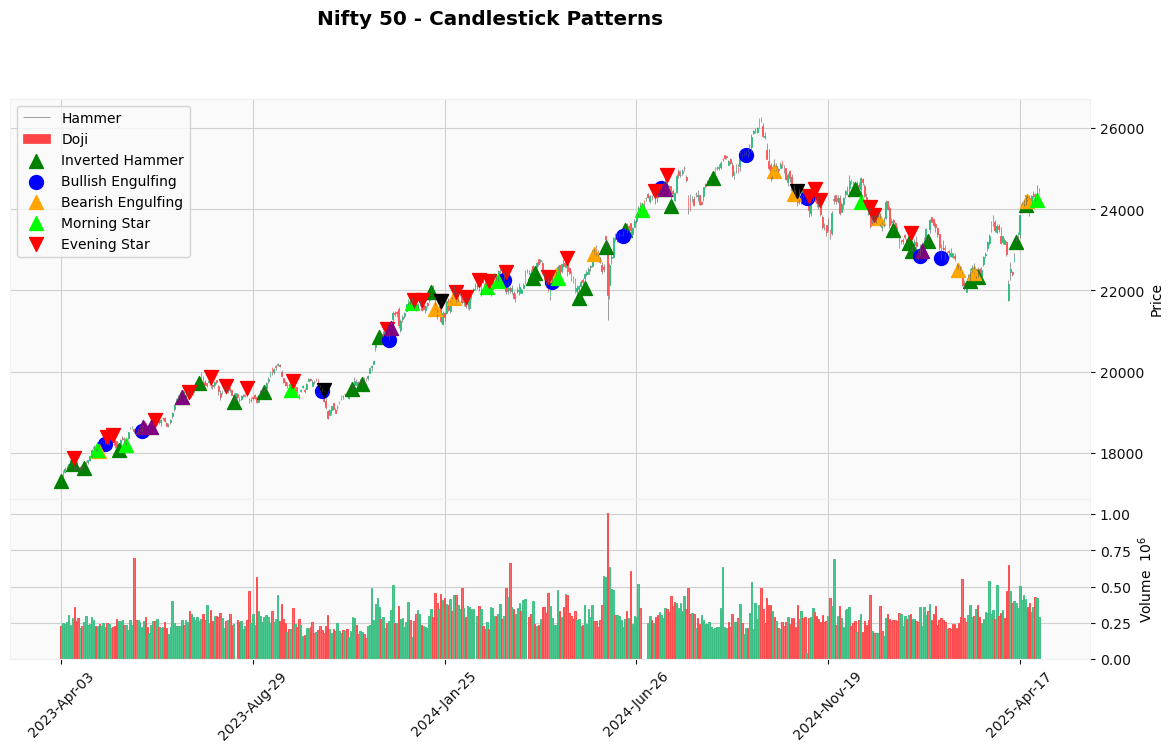

In [18]:
# Load CSV stock data using your custom loader
stock_path = "../data/^NSEI_2023-04-01_to_2025-05-06.csv"
stock_data = DataLoder(stock_path)

# If DataLoder returns 0 (error), exit
if isinstance(stock_data, int) and df == 0:
    print("Failed to load stock data.")
else:
    # Prepare candlestick pattern map
    patterns = {
        "Hammer": detect_hammer,
        "Doji": detect_doji,
        "Inverted Hammer": detect_inverted_hammer,
        "Bullish Engulfing": detect_bullish_engulfing,
        "Bearish Engulfing": detect_bearish_engulfing,
        "Morning Star": detect_morning_star_with_trend,
        "Evening Star": detect_evening_star_with_trend
    }

    # Plot detected patterns
    plot_candlestick_patterns(
        data=stock_data,
        pattern_functions=patterns,
        stock_name="Nifty 50"
    )


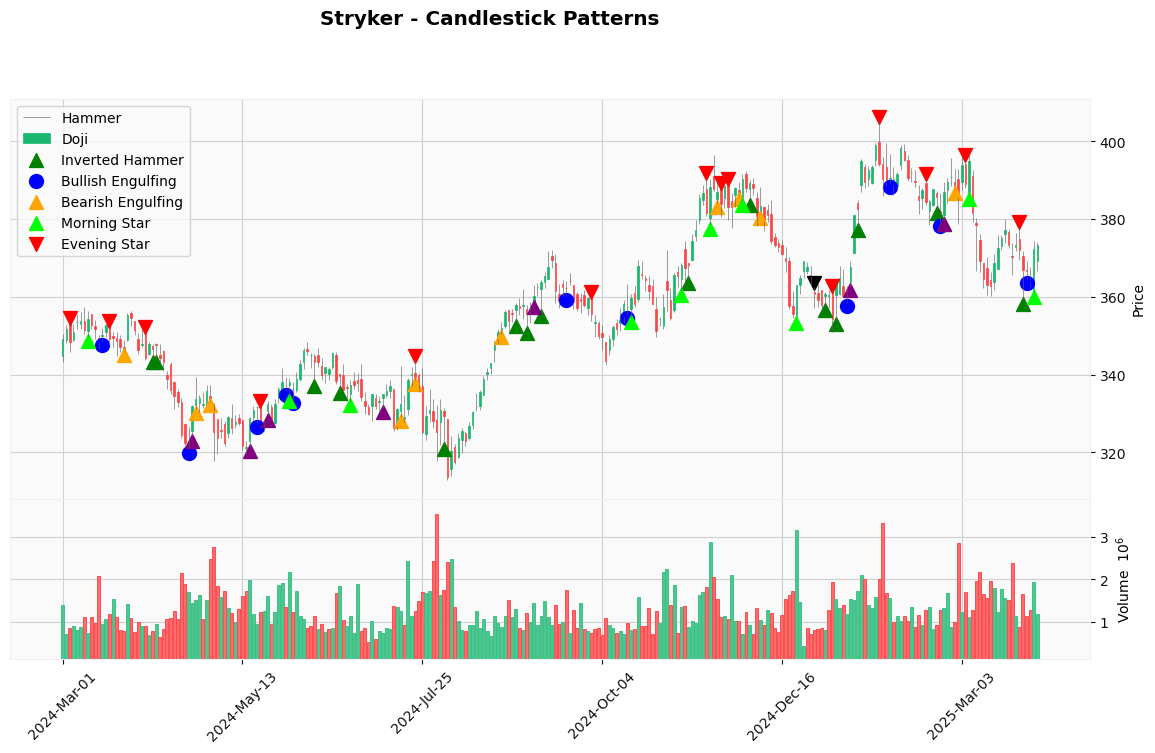

In [19]:
# Load CSV stock data using your custom loader
stock_path = "../data/SYK_2022-04-01_to_2025-05-06.csv"
stock_data = DataLoder(stock_path)

# If DataLoder returns 0 (error), exit
if isinstance(stock_data, int) and df == 0:
    print("Failed to load stock data.")
else:
    # Prepare candlestick pattern map
    patterns = {
        "Hammer": detect_hammer,
        "Doji": detect_doji,
        "Inverted Hammer": detect_inverted_hammer,
        "Bullish Engulfing": detect_bullish_engulfing,
        "Bearish Engulfing": detect_bearish_engulfing,
        "Morning Star": detect_morning_star_with_trend,
        "Evening Star": detect_evening_star_with_trend
    }

    # Plot detected patterns
    plot_candlestick_patterns(
        data=stock_data,
        pattern_functions=patterns,
        stock_name="Stryker",
        start_date="2024-03-01",
        end_date="2025-04-01"
    )

## Technical Indicators